# Models exploration 
- This notebook contains BERT model and MeanTeacher BERT model

Issue: 



TODO:

- Need to decide maxlen 
- ensemble technique
- better loss function
- ramp down function



# Installation, Importing, and declaration 

In [ ]:
import gc 
gc.collect()

0

In [ ]:
# installing requirements
# !pip install transformers 
# !pip install nlpaug
!pip install textattack

     |████████████████████████████████| 368kB 8.2MB/s 
     |████████████████████████████████| 102kB 16.2MB/s 
     |████████████████████████████████| 20.1MB 50.2MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 61kB 11.2MB/s 
     |████████████████████████████████| 2.5MB 35.6MB/s 
     |████████████████████████████████| 778kB 43.6MB/s 
     |████████████████████████████████| 266kB 35.7MB/s 
     |████████████████████████████████| 286kB 56.0MB/s 
     |████████████████████████████████| 3.3MB 20.7MB/s 
     |████████████████████████████████| 901kB 48.5MB/s 
     |████████████████████████████████| 245kB 57.2MB/s 
     |████████████████████████████████| 122kB 52.5MB/s 
     |████████████████████████████████| 19.7MB 1.5MB/s 
     |████████████████████████████████| 71kB 12.4MB/s 
     |████████████████████████████████| 983kB 43.8MB/s 
     |████████████████████████████████| 1.2MB 45.4MB/s 
     |████████████████████████████████| 798kB 49.3

In [ ]:
# importing libraries 
import os 
import pandas as pd 
import numpy as np

import tensorflow as tf 
from tensorflow.keras.layers import LSTM, Bidirectional,Dropout, Dense, Embedding, Input 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,precision_recall_curve,precision_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

import transformers
from transformers import AutoTokenizer, TFAutoModel, TFDistilBertModel, TFBertModel

from pathlib import Path
import datetime

In [ ]:


# Parameter declaration 
max_len= 100
learning_rate= 2e-5 
epochs= 3
batch_size=4
alpha=0.999
ratio=0.5

# columns names 
feature_col='tweet'
target_col='label'
aug_col='aug_tweet'
target_classes=['real','fake']
mapping_dict={target_classes[0]:0,target_classes[1]:1}

# Similarity Column 
cosine_sim='CosineSim'
wmd_sim='Wmd'
semantic_sim='Semantic_sim'


#pretrained_weights 
pretrained_weights= 'bert-base-uncased'#'distilbert-base-uncased' 

In [ ]:
os.chdir('/content/drive/MyDrive/Master Thesis/')
# Training data location
df_train_loc= 'codalab/PreprocessedData/pr_train.csv'
df_test_loc= 'codalab/PreprocessedData/pr_test.csv'
df_val_loc = 'codalab/PreprocessedData/pr_val.csv'

# Adversarial unlabeled data location 
df_aug_syn_un_loc= 'codalab/AugmentedData/aug_synonym.csv'
df_aug_con_un_loc='codalab/AugmentedData/aug_context.csv'
df_aug_bt_un_loc= 'codalab/AugmentedData/aug_backtranslated.csv'

# Adversarial test data 
df_aug_syn_test_loc='codalab/AugmentedData/adv_test_syn.csv'
df_aug_con_test_loc='codalab/AugmentedData/adv_test_context.csv'
df_aug_bt_test_loc='codalab/AugmentedData/adv_test_backTrans.csv'


# Reading dataset 

In [ ]:
def label_to_int(row):
    if row=='real':
        return 0
    else:
        return 1

In [ ]:
# training data 
df_train= pd.read_csv(df_train_loc,index_col=[0])
df_train= df_train.dropna()
df_train= df_train.drop_duplicates().reset_index(drop=True)
df_train[target_col]=df_train[target_col].map(lambda row: label_to_int(row))

# Test data 
df_test= pd.read_csv(df_test_loc,index_col=[0])
df_test= df_test.dropna()
df_test= df_test.drop_duplicates().reset_index(drop=True)
df_test[target_col]=df_test[target_col].map(lambda row: label_to_int(row))

# OPTIONAL: Validation data 
df_val= pd.read_csv(df_val_loc,index_col=[0])
df_val= df_val.dropna()
df_val= df_val.drop_duplicates().reset_index(drop=True)
df_val[target_col]=df_val[target_col].map(lambda row: label_to_int(row))


df_train.shape, df_test.shape, df_val.shape

((6097, 2), (2042, 2), (2068, 2))

In [ ]:
# Reading adversarial Unlabel data 
df_aug_syn_un= pd.read_csv(df_aug_syn_un_loc)
df_aug_syn_un= df_aug_syn_un.dropna().drop_duplicates().reset_index(drop=True)


df_aug_con_un= pd.read_csv(df_aug_con_un_loc)
df_aug_con_un= df_aug_con_un.dropna().drop_duplicates().reset_index(drop=True)

df_aug_bt_un= pd.read_csv(df_aug_bt_un_loc)
df_aug_bt_un= df_aug_bt_un.dropna().drop_duplicates().reset_index(drop=True)

# Combining all together 
df_aug_unlabel = df_aug_syn_un.append(df_aug_con_un).append(df_aug_bt_un)
df_aug_unlabel= df_aug_unlabel.sample(frac=1).reset_index(drop=True)
df_aug_unlabel[target_col]= df_aug_unlabel[aug_col].map(lambda row: label_to_int(row))

df_aug_syn_un.shape, df_aug_con_un.shape, df_aug_bt_un.shape, df_aug_unlabel.shape

((3946, 3), (1238, 3), (490, 3), (5674, 3))

In [ ]:
# Reading Adversarial Test data 
df_aug_syn_test= pd.read_csv(df_aug_syn_test_loc)
df_aug_syn_test= df_aug_syn_test.dropna().drop_duplicates().reset_index(drop=True)
df_aug_syn_test[target_col]=df_aug_syn_test[target_col].map(lambda row: label_to_int(row))

df_aug_con_test= pd.read_csv(df_aug_con_test_loc)
df_aug_con_test= df_aug_con_test.dropna().drop_duplicates().reset_index(drop=True)
df_aug_con_test[target_col]=df_aug_con_test[target_col].map(lambda row: label_to_int(row))

df_aug_bt_test= pd.read_csv(df_aug_bt_test_loc)
df_aug_bt_test= df_aug_bt_test.dropna().drop_duplicates().reset_index(drop=True)
df_aug_bt_test[target_col]=df_aug_bt_test[target_col].map(lambda row: label_to_int(row))

# Combining all together 
df_aug_test = df_aug_syn_test.append(df_aug_con_test).append(df_aug_bt_test)
df_aug_test= df_aug_test.sample(frac=1)

df_aug_syn_test.shape, df_aug_con_test.shape, df_aug_bt_test.shape, df_aug_test.shape

((1983, 6), (615, 6), (595, 6), (3193, 6))

# Test data Similarity Filtering

In this section, we can filter our test data according to similarity. 
Constraint:
- Sentence must not be same and it should not differ with same range. 0.8< cosine similarity < 0.95 [0-1]
- There must be change in words. 0 < word moving distance< 1.0
- Sentence must be semantically similar. 0 < semantic_similarity < 5

	 	 **Synonym Augmentation**
Cosine Similarity statistics: count    1983.000000
mean        0.756311
std         0.096919
min         0.392181
25%         0.693809
50%         0.762294
75%         0.829833
max         0.974330
Name: CosineSim, dtype: float64
WMD Similarity statistics: count    1983.000000
mean        0.235261
std         0.101027
min         0.018135
25%         0.167748
50%         0.220130
75%         0.286053
max         0.922290
Name: Wmd, dtype: float64
Semantic Similarity statistics: count    1983.000000
mean        4.276731
std         0.361495
min         2.172131
25%         4.052565
50%         4.370785
75%         4.564105
max         4.809975
Name: Semantic_sim, dtype: float64


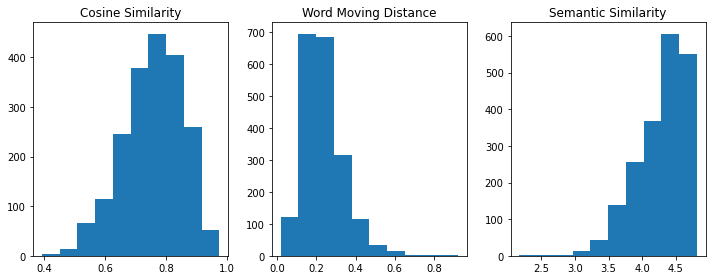


	 	 **Context Augmentation**
Cosine Similarity statistics: count    615.000000
mean       0.536371
std        0.085645
min        0.190874
25%        0.492502
50%        0.541544
75%        0.588364
max        0.787796
Name: CosineSim, dtype: float64
WMD Similarity statistics: count    615.000000
mean       0.486709
std        0.132039
min        0.168102
25%        0.388621
50%        0.470444
75%        0.569218
max        0.998268
Name: Wmd, dtype: float64
Semantic Similarity statistics: count    615.000000
mean       3.616030
std        0.635835
min        1.182690
25%        3.210384
50%        3.655582
75%        4.116805
max        4.722283
Name: Semantic_sim, dtype: float64


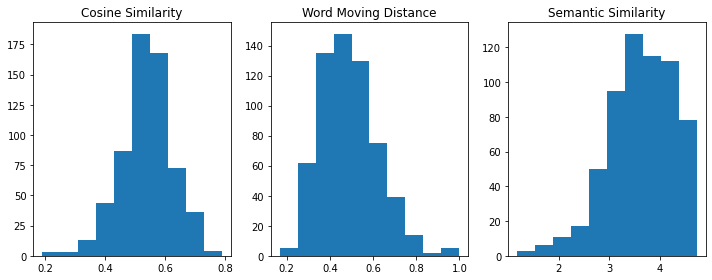


	 	 **BackTranslation Augmentation**
Cosine Similarity statistics: count    595.000000
mean       0.618749
std        0.180326
min        0.067436
25%        0.486187
50%        0.622633
75%        0.754897
max        1.000000
Name: CosineSim, dtype: float64
WMD Similarity statistics: count    595.000000
mean       0.305288
std        0.168176
min        0.000000
25%        0.195596
50%        0.274172
75%        0.396232
max        1.865592
Name: Wmd, dtype: float64
Semantic Similarity statistics: count    595.000000
mean       4.256623
std        0.538834
min        1.575664
25%        3.914784
50%        4.469916
75%        4.676876
max        4.815845
Name: Semantic_sim, dtype: float64


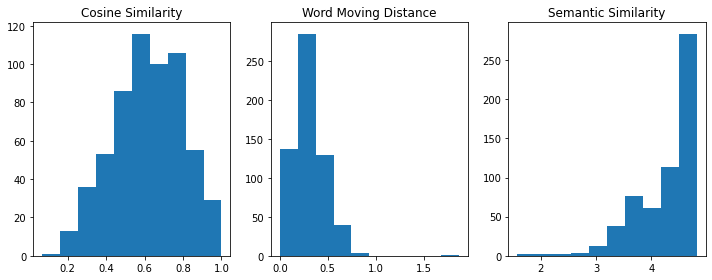

In [ ]:
# checking average similarity score in the test dataset
def similarity_description(df):
  print(f'Cosine Similarity statistics: {df[cosine_sim].describe()}')
  print(f'WMD Similarity statistics: {df[wmd_sim].describe()}')
  print(f'Semantic Similarity statistics: {df[semantic_sim].describe()}')
  
  fig, axs = plt.subplots(1, 3,figsize=(10,4),tight_layout=True)
  # We can set the number of bins with the `bins` kwarg
  axs[0].hist(df[cosine_sim])
  axs[0].set_title('Cosine Similarity')
  axs[1].hist(df[wmd_sim])
  axs[1].set_title('Word Moving Distance')
  axs[2].hist(df[semantic_sim])
  axs[2].set_title('Semantic Similarity')
  plt.show()

print('\t \t **Synonym Augmentation**')
similarity_description(df_aug_syn_test)
print('\n\t \t **Context Augmentation**')
similarity_description(df_aug_con_test)
print('\n\t \t **BackTranslation Augmentation**')
similarity_description(df_aug_bt_test)

In [ ]:
# Now adjust the threshold accordingly
cos_sim_thres=[0.80,0.99]
wmd_thres=[0.1,0.95]
semantic_sim_thres=[4.0,4.9]

# filtering the test data according to the threshold
def filter_similarity(df, aug_type='syn'):
  '''
  aug_type: str-> 'syn','con','bt'
  Filtering the dataframe accoring to the similarity threshold.
  - For synonym augmentation we need cosine similarity ,word moving distance, and semantic similarity
  - For Backtranslation, we just need semantic similarity and cosine similarity
  - For context , we need semantic similarity only
  '''
  if aug_type is 'syn':
    df=df[(df[cosine_sim]>cos_sim_thres[0]) & (df[cosine_sim]<cos_sim_thres[1]) ]
    df=df[(df[wmd_sim]>wmd_thres[0]) & (df[wmd_sim]<wmd_thres[1]) ]
    df=df[(df[semantic_sim]>semantic_sim_thres[0]) & (df[semantic_sim]<semantic_sim_thres[1]) ].reset_index(drop=True)
  elif aug_type is 'bt':
    df=df[(df[cosine_sim]>cos_sim_thres[0]) & (df[cosine_sim]<cos_sim_thres[1])]
    df=df[(df[semantic_sim]>semantic_sim_thres[0]) & (df[semantic_sim]<semantic_sim_thres[1]) ].reset_index(drop=True)
  else:
    df=df[(df[semantic_sim]>semantic_sim_thres[0]) & (df[semantic_sim]<semantic_sim_thres[1]) ].reset_index(drop=True)

  return df 

df_aug_syn_fil_test=filter_similarity(df_aug_syn_test,'syn')
df_aug_con_fil_test=filter_similarity(df_aug_con_test,'con')
df_aug_bt_fil_test=filter_similarity(df_aug_bt_test,'bt')


# concatinating the test data 
df_aug_fil_test = df_aug_syn_fil_test.append(df_aug_con_fil_test).append(df_aug_bt_fil_test)
df_aug_fil_test= df_aug_fil_test.sample(frac=1).reset_index(drop=True)


df_aug_fil_test

,aug_tweet,label,tweet,CosineSim,Wmd,Semantic_sim
0,subhan allah after corona computer virus china...,1,subhan allah after corona virus china govt lif...,0.812998,0.167988,4.595495
1,the trump or democratic united state of americ...,1,the president of the united state of america d...,0.655966,0.461012,4.522346
2,sweden to be extradited to joined state for vi...,1,sweden to be extradited to united state for vi...,0.827863,0.151374,4.694795
3,woman burned her hand during putting on wood s...,1,woman burned her hand while putting on the sto...,0.580795,0.343690,4.535205
4,offering essential cancer care in scientific m...,0,offering essential cancer care in the new norm...,0.541544,0.571269,4.042974
...,...,...,...,...,...,...
833,indiafightscorona covid recovery exceed active...,0,indiafightscorona covid recovery exceed active...,0.806290,0.319467,4.297663
834,coronavirus patient role bite a doctor jugular...,1,coronavirus patient bite a doctor jugular in t...,0.895532,0.179187,4.694243
835,commonwealth reported more than 23k new casefu...,0,state reported more than 23k new case in line ...,0.836967,0.150189,4.361091
836,at the height of the covid pandemic in young y...,0,at the height of the covid pandemic in new yor...,0.854676,0.238499,4.667443


In [ ]:
t

## Label Distribution

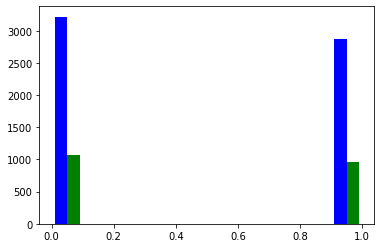

In [ ]:
# Label distribution of train and test dataset

plt.hist([df_train[target_col],df_test[target_col]],color=['blue','green'])
plt.show()

# Functions Declaration


Functions :
- Data Splitter 
- Creating Tokenizer 
- Convert to category 
- Data Tokenization 
- Evaluation 
- Augmentation Evaluation

In [ ]:
# in case we need to perform splitting 
def dataset_split(dataset,test_size):
    '''Split the dataframe into train and test '''
    df_train=dataset.sample(frac=(1-test_size),random_state=200) #random state is a seed value
    df_test=df.drop(df_train.index)
    df_train= df_train.reset_index(drop=True)
    df_test=df_test.reset_index(drop=True)
    return df_train,df_test

# Converting to categories 
def convert_to_category(target, n_classes=2):
    return to_categorical(target,n_classes)

#Creating tokenizer
def create_tokenizer(pretrained_weights='distilbert-base-uncased'):
    '''Function to create the tokenizer'''

    tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
    return tokenizer

#Tokenization of the data
def data_tokenization(dataset,feature_name,pretrained_weights,max_len,tokenizer):
    '''dataset: Pandas dataframe with feature name is column name 
    Pretrained_weights: selected model 
    RETURN: [input_ids, attention_mask]'''

    tokens = dataset[feature_name].apply(lambda x: tokenizer(x,return_tensors='tf', 
                                                            truncation=True,
                                                            padding='max_length',
                                                            max_length=max_len, 
                                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    # if we have label column
    if (target_col in dataset.columns):
        y= convert_to_category(dataset[target_col],2)
        return [input_ids,attention_mask], y, tokenizer.vocab_size
    else:
        return [input_ids,attention_mask]

# Model Evaluation 
def evaluation(model,x_test,y_test,n_class=2):
    '''
    Evaluation of the model in case you have test data in numpy array format
    Return- predicted label and accuracy
    '''
    y_pred= model.predict(x_test)
    if n_class>1:
        y_pred=tf.argmax(y_pred,1)
        y_true=tf.argmax(y_test,1)
    else:
        y_true=y_test
    cl_r=classification_report(y_true,y_pred,output_dict=True)
    # print(classification_report(y_true,y_pred))
    return y_pred, cl_r['accuracy']


# Augmented Data Evaluation 
def augmentation_evaluation(df_aug,model,tokenizer, only_input_ids=False, output_result=False):
    '''
    Function to evaluate the augmented and orignial test data
    in case you have dataframe for prediction
    Only_input_ids: if you need only input ids from tokenizer
    output_result: True return the  original and augmentated accuracy
    along with the df
    Return: df with prediction and it will write in the report file
    '''
    try:
        if only_input_ids:
            [x_orig,_],y,_ = data_tokenization(df_aug,feature_col,pretrained_weights,max_len,tokenizer)
            [x_aug,_],_,_ = data_tokenization(df_aug,aug_col,pretrained_weights,max_len,tokenizer)
        else:
            x_orig,y,_ = data_tokenization(df_aug,feature_col,pretrained_weights,max_len,tokenizer)
            x_aug,_,_ = data_tokenization(df_aug,aug_col,pretrained_weights,max_len,tokenizer)
    except:
        pass
    df_result=df_aug.copy()
   
    y_pred,ori_acc=evaluation(model,x_orig,y)
    df_result['original_pred']= y_pred

    
    y_pred,aug_acc=evaluation(model,x_aug,y)
    df_result['aug_pred']=y_pred

    if output_result:
      return df_result,ori_acc,aug_acc
    else:
      return




# Report Writing

This section is related to writing required details in dataframe and saving in csv format.

In [ ]:
# creating report df dataframe
def create_report():
  '''
  Creating the dataframe for report
  '''
  report_df = pd.DataFrame(columns=['Date', 'Model','Train_size',
                                    'Aug_Test_size', 'Type','Hyperparameters',
                                    'Original_Accuracy','AA_Accuracy','Perturbation',
                                    'Avg_Sem_Sim','Avg_Cos_Similarity','Avg_WMD','Comment'])

  return report_df


#Logging the details
def report_writing(model,tokenizer,model_name,df_test,type_of_aug,comment,only_input=False):
  '''
  Function to write the evaluation metrics in the report csv file.
  Input:
  model- model to evaluate
  df_test- test dataframe, must have original text, aug text, label, cosine sim, wmd, similarity
  hyperparamter_details- epochs, batch_size, alpha, ratio
  TODO: Perturbation percentage
  '''
  # accessing the details
  df_result, ori_acc, aug_acc=augmentation_evaluation(df_test,model,tokenizer,only_input_ids=only_input, output_result=True)
  print(f'Original Accuracy : {ori_acc}, Accuracy after Attack : {aug_acc}')
  train_size=df_train.shape[0]
  test_size=df_test.shape[0]
  hyperparameters=[epochs,learning_rate,batch_size,alpha,ratio,max_len,pretrained_weights]
  avg_sem_sim=df_test[semantic_sim]


  #creating the report
  report_df=create_report()

  #adding in the dataframe
  x = datetime.datetime.now()
  report_df = report_df.append({'Date' : x.strftime("%c"), 'Model' :model_name,'Train_size': train_size ,
                                'Aug_Test_size': test_size, 'Type': type_of_aug,'Hyperparameters': hyperparameters,
                                'Original_Accuracy': ori_acc,'AA_Accuracy':aug_acc,'Perturbation': None,
                                'Avg_Sem_Sim': df_test[semantic_sim].mean(),'Avg_Cos_Similarity':df_test[cosine_sim].mean(),
                                'Avg_WMD':df_test[wmd_sim].mean(),'Comment':comment
                                  }, ignore_index=True)  
 
  file_l = Path('Result/'+model_name+'_'+'.csv')

  if file_l.exists():
      report_df.to_csv(file_l,mode='a', header= False , index = False)
  else:
      report_df.to_csv(file_l,mode='w', header= True , index= False)
  return 

# Supervised Model 
Baseline model to verify model performance. 


In [ ]:
# Supervised model declaration 
def seq_model(maxlen,vocab_size):
    input= tf.keras.Input(shape=(max_len,))
    x= Embedding(vocab_size,max_len,input_length=None)(input)
    x= Bidirectional(LSTM(128))(x)
    x= Dense(64)(x)
    x= Dropout(0.2)(x)
    x=Dense(32)(x)
    x= Dense(16)(x)
    output=Dense(2,activation='sigmoid')(x)
    model= Model(input,output)
    model.compile(tf.keras.optimizers.Adam(learning_rate= learning_rate),loss= tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [ ]:
# tokenization 
tokenizer= create_tokenizer()
[x_train,_],y_train,vocab_size= data_tokenization(df_train,feature_col,pretrained_weights,max_len,tokenizer)
[x_test,_],y_test,_= data_tokenization(df_test,feature_col,pretrained_weights,max_len,tokenizer)

In [ ]:
#training
bilstm_model=seq_model(max_len,vocab_size)
# bilstm_model.summary()
with tf.device('/GPU:0'):
    bilstm_model.fit(x_train,y_train,
                     batch_size=batch_size,
                     epochs=epochs+4,
                     verbose=1)

Epoch 1/7
 830/1525 [===============>..............] - ETA: 1:49 - loss: 0.6533 - accuracy: 0.6295

KeyboardInterrupt: ignored

In [ ]:
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_syn_fil_test,'syn','Bilstm model', only_input=True)
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_con_fil_test,'con','Bilstm model', only_input= True)
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_bt_fil_test,'bt','Bilstm model', only_input= True)
report_writing(bilstm_model,tokenizer,'BILSTM',df_aug_fil_test,'all','Bilstm model', only_input=True)

In [ ]:
# saving the model
bilstm_model.save('SavedModels/Bilstm_model.h5')

In [ ]:
test_model=tf.keras.models.load_model('SavedModels/Bilstm_model.h5')

report_writing(test_model,tokenizer,'BILSTM',df_aug_syn_fil_test,'syn','Bilstm model', only_input=True)

# BERT Model 

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def bert_model(max_len,pretrained_weights):
    '''BERT model creation with pretrained weights
    max_len: input length '''
    # Define weight initializer with a random seed to ensure reproducibility
    # weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)
    # DISTILBERT_DROPOUT = 0.2
    # DISTILBERT_ATT_DROPOUT = 0.2
 
    # # Configure DistilBERT's initialization
    # config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
    #                         attention_dropout=DISTILBERT_ATT_DROPOUT, 
    #                         output_hidden_states=True)
                          
    # The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
    # and without any specific head on top.
    # distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

    bert=TFAutoModel.from_pretrained(pretrained_weights)
    
    # This is must if you would like to train the layers of language models too.
    for layer in bert.layers:
        layer.trainable = True

    # parameter declaration
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # declaring inputs, BERT take input_ids and attention_mask as input
    input_ids= Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
    attention_mask=Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

    bert= bert(input_ids,attention_mask=attention_mask)
    x= bert[0][:,0,:]
    x=tf.keras.layers.Dropout(0.2)(x)
    x= tf.keras.layers.Dense(64)(x)
    x=tf.keras.layers.Dense(32)(x)

    output=tf.keras.layers.Dense(2,activation='sigmoid')(x)

    model=Model(inputs=[input_ids,attention_mask],outputs=[output])
    # compiling model 
    model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
    return model

def bert_model1():
    model=transformers.DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
    # model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
tokenizer=create_tokenizer(pretrained_weights)
x_train,y_train,vocab_size= data_tokenization(df_train,feature_col,pretrained_weights,max_len,tokenizer)
x_test,y_test,_= data_tokenization(df_test,feature_col,pretrained_weights,max_len,tokenizer)

In [ ]:
bert=bert_model(max_len,pretrained_weights)
bert.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
with tf.device('/GPU:0'):
    bert.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/3
1525/1525 [==============================] - 190s 115ms/step - loss: 0.2462 - accuracy: 0.8972
Epoch 2/3
1525/1525 [==============================] - 178s 116ms/step - loss: 0.0812 - accuracy: 0.9715
Epoch 3/3
1525/1525 [==============================] - 178s 117ms/step - loss: 0.0321 - accuracy: 0.9884


In [ ]:
evaluation(bert,x_test,y_test)

(<tf.Tensor: shape=(2042,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 0])>,
 0.9490695396669931)

In [ ]:
report_writing(bert,tokenizer,'BERT',df_aug_syn_fil_test,'syn','BERT model')
report_writing(bert,tokenizer,'BERT',df_aug_con_fil_test,'con','BERT model')
report_writing(bert,tokenizer,'BERT',df_aug_bt_fil_test,'bt','BERT model')
report_writing(bert,tokenizer,'BERT',df_aug_fil_test,'all','BERT model')

Original Accuracy : 0.9535714285714286, Accuracy after Attack : 0.9446428571428571
Original Accuracy : 0.8842105263157894, Accuracy after Attack : 0.8578947368421053
Original Accuracy : 0.8977272727272727, Accuracy after Attack : 0.9090909090909091
Original Accuracy : 0.931980906921241, Accuracy after Attack : 0.9212410501193318


In [ ]:
#saving the model 
bert.save_weights('SavedModels/BERT_model.h5')

In [ ]:
#loading the model 
test_model=tf.keras.models.load_model('SavedModels/BERT_model.h5')

report_writing(test_model,tokenizer,'BILSTM',df_aug_syn_fil_test,'syn','BERT model', only_input=True)

Original Accuracy : 0.9482142857142857, Accuracy after Attack : 0.9339285714285714


# Adversarial Mean Teacher BERT

## Functions

In [ ]:
# ref:https://github.com/CuriousAI/mean-teacher/tree/master/tensorflow/mean_teacher  updated according to our need .
def cal_classification_cost(logits, labels) :
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating
    the binary cross entropy .
    """
    # applicable = tf.not_equal(labels, -1)
    # Change -1s to zeros to make cross-entropy computable
    # labels = tf.where(applicable, labels, tf.zeros_like(labels))
    loss=tf.reduce_sum(tf.keras.losses.categorical_crossentropy(labels, logits))
    # tf.keras.losses.kl_divergence()
    # Retain costs only for labeled
    # per_sample=tf.where(applicable[:,1], per_sample, tf.zeros_like(per_sample))
    # Take mean over all examples, not just labeled examples.
    # loss = tf.math.divide(tf.reduce_mean(tf.reduce_sum( per_sample ) ), np.shape ( per_sample )[0] )
    # print('Classification Cost: ',loss)
    return loss

def cal_overall_cost(x_train,y_train,x_unlabel,student, teacher):
    #TODO: need to include noising technique
    ratio=0.5
    logits = student(x_train)
    classification_cost = cal_classification_cost(logits, y_train)
    tar_student = student(x_unlabel)
    tar_teacher = teacher(x_unlabel)
    
    consistency_cost = cal_consistency_cost( tar_student, tar_teacher)
    # print('consistency_cost : ',consistency_cost)
    return (ratio * classification_cost) + ((1 - ratio) * consistency_cost)

# function for consistency cost
def cal_consistency_cost(student_output, teacher_output) :
    return tf.reduce_sum(tf.losses.mean_squared_error(student_output, teacher_output ))

def ema(student_model, teacher_model, alpha=0.999) :
    # taking weights
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()
    # length must be equal otherwise it will not work
    assert len(student_weights ) == len(teacher_weights ), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format (
        len(student_weights ), len (teacher_weights ) )
    new_layers = []
    for i, layers in enumerate ( student_weights ) :
        new_layer = alpha * (teacher_weights[i]) + (1 - alpha) * layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model

def data_slices(x_train,y_train,x_unlabel,batch_size):
    train_dataset = tf.data.Dataset.from_tensor_slices( (x_train[0],x_train[1], y_train) )
    train_dataset = train_dataset.shuffle( buffer_size=1024 ).batch(batch_size)

    unlabel_dataset = tf.data.Dataset.from_tensor_slices( (x_unlabel[0],x_unlabel[1]) )
    unlabel_dataset = unlabel_dataset.shuffle( buffer_size=1024 ).batch(batch_size)
    return train_dataset, unlabel_dataset

In [ ]:
def train_mean_teacher(x_train, y_train, x_unlabel, epochs,batch_size,lr,alpha):
    # preparing the training dataset
    train_dataset,unlabel_dataset = data_slices(x_train, y_train,x_unlabel,batch_size)
    # declaring optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # creating model
    student = bert_model(max_len,pretrained_weights)#call for the model here
    teacher = bert_model(max_len,pretrained_weights) #call for model here
    print('alpha:', alpha)

    # declaring metrics
    train_metrics = tf.keras.metrics.BinaryAccuracy(name='Binary_Accuracy')
    progbar = tf.keras.utils.Progbar(len(train_dataset), stateful_metrics=['Accuracy', 'Overall_Loss'])
    # epochs = args.epochs
    step_counter = 0
    for epoch in range(epochs):
        tf.print(f'\nepoch {epoch + 1}')
        # iterator_noise = iter(noise_dataset)
        for step, ((input_ids,attention_ids, y_batch_train),(input_ids_un,attention_ids_un)) in enumerate(zip(train_dataset,unlabel_dataset)):
            with tf.GradientTape() as tape:
                overall_cost = cal_overall_cost([input_ids,attention_ids], 
                                                y_batch_train,
                                                [input_ids_un,attention_ids_un],
                                                student, 
                                                teacher)

            grads = tape.gradient(overall_cost, student.trainable_weights)
            optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, student.trainable_weights) if grad is not None)
            # applying student weights to teacher
            step_counter += 1
            teacher = ema(student, teacher, alpha=alpha)
            # calculating training accuracy
            logits_t = teacher([input_ids,attention_ids])
            train_acc = train_metrics(tf.argmax(y_batch_train, 1), tf.argmax(logits_t, 1))
            progbar.update(step, values=[('Accuracy', train_acc), ('Overall_Loss', overall_cost)])

    return student, teacher


In [ ]:
# Training
tokenizer=create_tokenizer(pretrained_weights)
x_train,y_train,vocab_size= data_tokenization(df_train,feature_col,pretrained_weights,max_len,tokenizer)
x_test,y_test,_= data_tokenization(df_test,feature_col,pretrained_weights,max_len,tokenizer)
x_unlabel,_,_=data_tokenization(df_aug_unlabel,aug_col,pretrained_weights,max_len,tokenizer)

In [ ]:
with tf.device('/GPU:0'):
    student, teacher= train_mean_teacher(x_train, y_train, x_unlabel, 
                                         epochs,batch_size,
                                         learning_rate,alpha)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


alpha: 0.999

epoch 1
1418/1525 [==========================>...] - ETA: 3:40 - Accuracy: 0.5969 - Overall_Loss: 0.0959
epoch 2
1418/1525 [==========================>...] - ETA: 3:40 - Accuracy: 0.7898 - Overall_Loss: 0.0206
epoch 3
1418/1525 [==========================>...] - ETA: 3:37 - Accuracy: 0.8593 - Overall_Loss: 0.1092

In [ ]:
teacher.save_weights('SavedModels/BERT_teacher.h5')

In [ ]:
evaluation(teacher,x_test,y_test)

In [ ]:
print('synonym result')
# augmentation_evaluation(df_aug_syn_fil_test, teacher,tokenizer,only_input_ids=False)
report_writing(teacher,tokenizer,'BERT',df_aug_syn_fil_test,'syn','teacher')

print('context result')
# augmentation_evaluation(df_aug_con_fil_test, teacher,tokenizer,only_input_ids=False)
report_writing(teacher,tokenizer,'BERT',df_aug_con_fil_test,'con','teacher')

print('Back Translation result')
# augmentation_evaluation(df_aug_bt_fil_test, teacher,tokenizer,only_input_ids=False)
report_writing(teacher,tokenizer,'BERT',df_aug_bt_fil_test,'bt','teacher')

print('total result')
# augmentation_evaluation(df_aug_fil_test, teacher,tokenizer,only_input_ids=False)
report_writing(teacher,tokenizer,'BERT',df_aug_fil_test,'all','teacher')


synonym result
Original Accuracy : 0.9625, Accuracy after Attack : 0.9571428571428572
context result
Original Accuracy : 0.9263157894736842, Accuracy after Attack : 0.8842105263157894
Back Translation result
Original Accuracy : 0.9090909090909091, Accuracy after Attack : 0.9090909090909091
total result
Original Accuracy : 0.9486873508353222, Accuracy after Attack : 0.9355608591885441


In [ ]:
print('synonym result')
augmentation_evaluation(df_aug_syn_test, student,tokenizer,only_input_ids=False)

print('context result')
augmentation_evaluation(df_aug_con_test, student,tokenizer,only_input_ids=False)

print('Back Translation result')
augmentation_evaluation(df_aug_bt_test, student,tokenizer,only_input_ids=False)

print('total result')
augmentation_evaluation(df_aug_test, student,tokenizer,only_input_ids=False)

synonym result
Classification Report Original Test Data:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1053
           1       0.92      0.96      0.94       930

    accuracy                           0.94      1983
   macro avg       0.94      0.94      0.94      1983
weighted avg       0.94      0.94      0.94      1983

Classification Report Augmented Test Data:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1053
           1       0.90      0.96      0.93       930

    accuracy                           0.93      1983
   macro avg       0.93      0.93      0.93      1983
weighted avg       0.93      0.93      0.93      1983

context result
Classification Report Original Test Data:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80       142
           1       0.92      0.97      0.95       473

    accuracy             

,aug_tweet,label,tweet,CosineSim,Wmd,Semantic_sim,original_pred,aug_pred
422,citizenry are move doorway to door in colorado...,1,people are going door to door in colorado spri...,0.682978,0.496806,4.606555,1,1
393,interspersed with strip club action rock lyric...,1,poledance and strip club controversy rock u wi...,0.427203,0.566371,3.553653,1,1
430,video show a family bonding results from novel...,1,video show a family that died from novel coron...,0.457624,0.541390,2.523447,1,1
402,certificate covide means of identification of ...,1,covid mean certificate of identification of va...,0.716812,0.078717,4.733989,1,1
402,president donald cornet make a moroccan sheikh...,1,president donald trump got a moroccan sheikh m...,0.706078,0.276563,4.030476,1,1
...,...,...,...,...,...,...,...,...
648,gov andrew cuomo wa plainly saying if we can s...,1,gov andrew cuomo wa simply saying if we can sh...,0.874091,0.178652,4.431146,1,1
86,only strong growing natural process combined w...,0,only aggressive action combined with national ...,0.670167,0.237426,4.148320,0,0
403,positioning prone to evil and the potential be...,0,prone positioning for severe covid ha potentia...,0.473939,0.283641,3.847135,0,1
252,we need to open the economy and get back to wo...,1,we need to open up the economy and get back to...,0.883635,0.223897,4.641836,1,1


In [ ]:
df_test_result= augmentation_evaluation(df_aug_test, teacher,tokenizer,only_input_ids=False)
df_test_result.to_csv('Result/df_test_result_jun26.csv')

Classification Report Original Test Data:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1334
           1       0.93      0.96      0.95      1859

    accuracy                           0.94      3193
   macro avg       0.94      0.93      0.94      3193
weighted avg       0.94      0.94      0.94      3193

Classification Report Augmented Test Data:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1334
           1       0.91      0.95      0.93      1859

    accuracy                           0.91      3193
   macro avg       0.92      0.91      0.91      3193
weighted avg       0.91      0.91      0.91      3193



In [ ]:
df_test_result

In [ ]:
df_test_result_mismatch=df_test_result[~(df_test_result['original_pred']==df_test_result['aug_pred'])]

# Text attack

In [ ]:
import numpy as np
import torch
import textattack

from textattack.models.wrappers import ModelWrapper

class CustomTensorFlowModelWrapper(ModelWrapper):
    def __init__(self, model):
        self.model = model

    def __call__(self, text_input_list):
        tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
        tokens=tokenizer(text_input_list,return_tensors='tf', 
                         truncation=True,
                         padding='max_length',
                         max_length=max_len, 
                         add_special_tokens=True)
        
        input_ids= []
        attention_mask=[]
        input_ids.append(tokens.input_ids)
        attention_mask.append(tokens.attention_mask)
        # input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)
        # text_array = np.array(text_input_list)
        preds = torch.tensor(self.model([input_ids, attention_mask]).numpy())
  
        return preds
class CustomTensorFlowModelWrapperSupervised(ModelWrapper):
    def __init__(self, model):
        self.model = model

    def __call__(self, text_input_list):
        tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
        tokens=tokenizer(text_input_list,return_tensors='tf', 
                         truncation=True,
                         padding='max_length',
                         max_length=max_len, 
                         add_special_tokens=True)
        
        input_ids= []
        input_ids.append(tokens.input_ids)
        # input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)
        # text_array = np.array(text_input_list)
        preds = torch.tensor(self.model(tokens.input_ids).numpy())
  
        return preds


textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:11<00:00, 42.4MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpjcbvjb3_.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


In [ ]:
df_test['len']=df_test.apply(lambda row: len(row[feature_col].split()),axis=1)
df_test_for_attack= df_test[(df_test['len']>5) & (df_test['len']<10)][[feature_col,target_col]].reset_index(drop=True)
df_test_for_attack=df_test_for_attack.sample(frac=1).reset_index(drop=True)
df_test_for_attack

,tweet,label
0,coronavirus franchising ended a government see...,0
1,news coronavirus suspect to be quarantined on ...,1
2,who ha declared covid an endemic disease,1
3,israel ha already developed a vaccine against ...,1
4,child will be separated from parent for corona...,1
...,...,...
126,factchecking ha israel already discovered a co...,1
127,could miley cyrus vagina hold clue to vaccine,1
128,the vaccine against the new coronavirus ha exi...,1
129,ag barr suggests an end to the coronavirus loc...,1


In [ ]:
#loading the model
BERT_model= bert_model(max_len,pretrained_weights) 
BERT_model.load_weights('SavedModels/BERT_model.h5')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
model_wrapper = CustomTensorFlowModelWrapper(BERT_model)
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes.bert_attack_li_2020 import BERTAttackLi2020
from textattack import Attacker

data=list(df_test_for_attack[:50].itertuples(index=False, name=None))
dataset = textattack.datasets.Dataset(data)
# dataset = HuggingFaceDataset("rotten_tomatoes", None, "test", shuffle=True)
# attack = PWWSRen2019.build(model_wrapper)
attack = BERTAttackLi2020.build(model_wrapper)
attack_args = textattack.AttackArgs(
    num_examples=50,
    log_to_csv="Result/bert_log.csv",
    disable_stdout=False,
    random_seed=42,
    query_budget=100
)
with tf.device('/GPU:0'):
  attacker = Attacker(attack, dataset,attack_args)
  attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'tensorflow.python.keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/bert_log.csv


  0%|          | 0/50 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 





  2%|▏         | 1/50 [00:17<14:02, 17.19s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   2%|▏         | 1/50 [00:17<14:02, 17.20s/it]

--------------------------------------------- Result 1 ---------------------------------------------
1 (73%) --> 0 (68%)

covid vaccine trial killed child in senegal

covid vaccine trial grew child in captive






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   4%|▍         | 2/50 [00:31<12:38, 15.80s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   4%|▍         | 2/50 [00:31<12:38, 15.81s/it]

--------------------------------------------- Result 2 ---------------------------------------------
1 (72%) --> 0 (51%)

could miley cyrus vagina hold clue to vaccine

could miley or vaa hold clue to vaccine






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   6%|▌         | 3/50 [01:32<24:13, 30.93s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   6%|▌         | 3/50 [01:32<24:13, 30.94s/it]

--------------------------------------------- Result 3 ---------------------------------------------
1 (73%) --> [FAILED]

local badass only wash hand for second handwashing coronalockdown






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   8%|▊         | 4/50 [02:31<29:07, 38.00s/it]

[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:   8%|▊         | 4/50 [02:32<29:08, 38.00s/it]

--------------------------------------------- Result 4 ---------------------------------------------
1 (73%) --> [FAILED]

muslimowned restaurant are spitting in food to spread coronavirus






[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  10%|█         | 5/50 [02:48<25:16, 33.70s/it]

[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  10%|█         | 5/50 [02:48<25:16, 33.70s/it]

--------------------------------------------- Result 5 ---------------------------------------------
1 (73%) --> [FAILED]

dr li wenliang discovered coffee can cure coronavirus






[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  12%|█▏        | 6/50 [02:57<21:43, 29.63s/it]

[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  12%|█▏        | 6/50 [02:57<21:43, 29.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
0 (71%) --> 1 (60%)

equity accuracy and quality question surround the coronavirus vaccine

equity accuracy and quality is surround the coronavirus vaccine






[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  14%|█▍        | 7/50 [03:06<19:08, 26.70s/it]

[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  14%|█▍        | 7/50 [03:06<19:08, 26.70s/it]

--------------------------------------------- Result 7 ---------------------------------------------
0 (73%) --> 1 (66%)

newly updated covid investigational drug and therapy

newly inn covid investigational drug and therapy






[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  16%|█▌        | 8/50 [04:05<21:28, 30.69s/it]

[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  16%|█▌        | 8/50 [04:05<21:28, 30.69s/it]

--------------------------------------------- Result 8 ---------------------------------------------
1 (70%) --> 0 (53%)

july ha le death than july despite pandemic

d ha le death than july despite panderosa






[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  18%|█▊        | 9/50 [04:15<19:22, 28.36s/it]

[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  18%|█▊        | 9/50 [04:15<19:22, 28.36s/it]

--------------------------------------------- Result 9 ---------------------------------------------
1 (72%) --> 0 (54%)

the vaccine against the new coronavirus ha existed since

the vaccine against the new coronamm ha existed since






[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  20%|██        | 10/50 [04:32<18:08, 27.21s/it]

[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10:  20%|██        | 10/50 [04:32<18:08, 27.21s/it]

--------------------------------------------- Result 10 ---------------------------------------------
1 (73%) --> [FAILED]

ugandan president announces the postponement of election






[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10:  22%|██▏       | 11/50 [04:34<16:12, 24.94s/it]

[Succeeded / Failed / Skipped / Total] 6 / 4 / 1 / 11:  22%|██▏       | 11/50 [04:34<16:12, 24.94s/it]

--------------------------------------------- Result 11 ---------------------------------------------
1 (57%) --> [SKIPPED]

conjunctivitis may sometimes be the only coronavirus symptom






[Succeeded / Failed / Skipped / Total] 6 / 4 / 1 / 11:  24%|██▍       | 12/50 [04:43<14:58, 23.64s/it]

[Succeeded / Failed / Skipped / Total] 7 / 4 / 1 / 12:  24%|██▍       | 12/50 [04:43<14:58, 23.64s/it]

--------------------------------------------- Result 12 ---------------------------------------------
1 (56%) --> 0 (60%)

u ha developed miracle drug remedesivir against covid

u the developed miracle drug remedesivir against covid






[Succeeded / Failed / Skipped / Total] 7 / 4 / 1 / 12:  26%|██▌       | 13/50 [04:58<14:08, 22.95s/it]

[Succeeded / Failed / Skipped / Total] 8 / 4 / 1 / 13:  26%|██▌       | 13/50 [04:58<14:09, 22.95s/it]

--------------------------------------------- Result 13 ---------------------------------------------
1 (70%) --> 0 (51%)

social medium post on covid are punishable offence now

social medium posting on covid are punishcommon offence now






[Succeeded / Failed / Skipped / Total] 8 / 4 / 1 / 13:  28%|██▊       | 14/50 [05:56<15:16, 25.46s/it]

[Succeeded / Failed / Skipped / Total] 9 / 4 / 1 / 14:  28%|██▊       | 14/50 [05:56<15:16, 25.46s/it]

--------------------------------------------- Result 14 ---------------------------------------------
1 (73%) --> 0 (64%)

raisin prevents clotting thus help to fight covid

raisin prevent clottiwith thus help to fight covid






[Succeeded / Failed / Skipped / Total] 9 / 4 / 1 / 14:  30%|███       | 15/50 [06:05<14:13, 24.38s/it]

[Succeeded / Failed / Skipped / Total] 10 / 4 / 1 / 15:  30%|███       | 15/50 [06:05<14:13, 24.38s/it]

--------------------------------------------- Result 15 ---------------------------------------------
1 (73%) --> 0 (52%)

news report say student taking comedk got covid

information report say student taking comedk got covid






[Succeeded / Failed / Skipped / Total] 10 / 4 / 1 / 15:  32%|███▏      | 16/50 [07:03<15:00, 26.48s/it]

[Succeeded / Failed / Skipped / Total] 10 / 5 / 1 / 16:  32%|███▏      | 16/50 [07:03<15:00, 26.49s/it]

--------------------------------------------- Result 16 ---------------------------------------------
1 (73%) --> [FAILED]

5g is the cause of the coronavirus pandemic






[Succeeded / Failed / Skipped / Total] 10 / 5 / 1 / 16:  34%|███▍      | 17/50 [07:20<14:15, 25.92s/it]

[Succeeded / Failed / Skipped / Total] 11 / 5 / 1 / 17:  34%|███▍      | 17/50 [07:20<14:15, 25.92s/it]

--------------------------------------------- Result 17 ---------------------------------------------
1 (72%) --> 0 (55%)

kid reach f k this shit stage of lockdown

know reach f at this shit stage of lock#






[Succeeded / Failed / Skipped / Total] 11 / 5 / 1 / 17:  36%|███▌      | 18/50 [07:29<13:19, 24.99s/it]

[Succeeded / Failed / Skipped / Total] 12 / 5 / 1 / 18:  36%|███▌      | 18/50 [07:29<13:19, 24.99s/it]

--------------------------------------------- Result 18 ---------------------------------------------
0 (72%) --> 1 (57%)

some coronavirus patient are experiencing chronic fatigue

some coronavirus patient are on chronic fatigue






[Succeeded / Failed / Skipped / Total] 12 / 5 / 1 / 18:  38%|███▊      | 19/50 [07:46<12:41, 24.57s/it]

[Succeeded / Failed / Skipped / Total] 13 / 5 / 1 / 19:  38%|███▊      | 19/50 [07:46<12:41, 24.57s/it]

--------------------------------------------- Result 19 ---------------------------------------------
1 (72%) --> 0 (56%)

corona virus must be stopped confirm irish music fan

ce virus country be be confirm irish music fan






[Succeeded / Failed / Skipped / Total] 13 / 5 / 1 / 19:  40%|████      | 20/50 [08:03<12:04, 24.17s/it]

[Succeeded / Failed / Skipped / Total] 13 / 6 / 1 / 20:  40%|████      | 20/50 [08:03<12:04, 24.17s/it]

--------------------------------------------- Result 20 ---------------------------------------------
1 (73%) --> [FAILED]

president donald trump announced commercialization of a vaccine






[Succeeded / Failed / Skipped / Total] 13 / 6 / 1 / 20:  42%|████▏     | 21/50 [08:17<11:26, 23.68s/it]

[Succeeded / Failed / Skipped / Total] 14 / 6 / 1 / 21:  42%|████▏     | 21/50 [08:17<11:26, 23.68s/it]

--------------------------------------------- Result 21 ---------------------------------------------
1 (73%) --> 0 (53%)

trump offer to pardon coronavirus newsinphoto covid coronavirusnyc

my offer to apologies coronavirus newsinphoto covid coronavirusnyc






[Succeeded / Failed / Skipped / Total] 14 / 6 / 1 / 21:  44%|████▍     | 22/50 [08:33<10:53, 23.34s/it]

[Succeeded / Failed / Skipped / Total] 15 / 6 / 1 / 22:  44%|████▍     | 22/50 [08:33<10:53, 23.34s/it]

--------------------------------------------- Result 22 ---------------------------------------------
1 (73%) --> 0 (51%)

say gov tony evers is pushing firearm confiscation order

ask coordinator tony evers is advocating firearm confiscation order






[Succeeded / Failed / Skipped / Total] 15 / 6 / 1 / 22:  46%|████▌     | 23/50 [08:42<10:13, 22.73s/it]

[Succeeded / Failed / Skipped / Total] 16 / 6 / 1 / 23:  46%|████▌     | 23/50 [08:42<10:13, 22.73s/it]

--------------------------------------------- Result 23 ---------------------------------------------
1 (70%) --> 0 (66%)

false positive result rate in pcr test is percent

non positive result rate in pcr test is percent






[Succeeded / Failed / Skipped / Total] 16 / 6 / 1 / 23:  48%|████▊     | 24/50 [08:49<09:33, 22.07s/it]

[Succeeded / Failed / Skipped / Total] 17 / 6 / 1 / 24:  48%|████▊     | 24/50 [08:49<09:33, 22.07s/it]

--------------------------------------------- Result 24 ---------------------------------------------
1 (69%) --> 0 (54%)

country were exporting covid diagnostic test instrument in

country were exporting covid testing test instrument in






[Succeeded / Failed / Skipped / Total] 17 / 6 / 1 / 24:  50%|█████     | 25/50 [09:03<09:03, 21.74s/it]

[Succeeded / Failed / Skipped / Total] 18 / 6 / 1 / 25:  50%|█████     | 25/50 [09:03<09:03, 21.74s/it]

--------------------------------------------- Result 25 ---------------------------------------------
1 (73%) --> 0 (68%)

chinese spy stole the coronavirus from a canadian lab

we spy stolen the coronavirus from a canadian lab






[Succeeded / Failed / Skipped / Total] 18 / 6 / 1 / 25:  52%|█████▏    | 26/50 [09:12<08:30, 21.27s/it]

[Succeeded / Failed / Skipped / Total] 19 / 6 / 1 / 26:  52%|█████▏    | 26/50 [09:12<08:30, 21.27s/it]

--------------------------------------------- Result 26 ---------------------------------------------
0 (71%) --> 1 (53%)

covid mortality risk in bystander cpr event

covid mortality of in bystander cpr event






[Succeeded / Failed / Skipped / Total] 19 / 6 / 1 / 26:  54%|█████▍    | 27/50 [09:22<07:58, 20.82s/it]

[Succeeded / Failed / Skipped / Total] 20 / 6 / 1 / 27:  54%|█████▍    | 27/50 [09:22<07:58, 20.82s/it]

--------------------------------------------- Result 27 ---------------------------------------------
1 (69%) --> 0 (63%)

who say that covid ha become endemic

who think that covid ha become endemic






[Succeeded / Failed / Skipped / Total] 20 / 6 / 1 / 27:  56%|█████▌    | 28/50 [09:31<07:28, 20.41s/it]

[Succeeded / Failed / Skipped / Total] 21 / 6 / 1 / 28:  56%|█████▌    | 28/50 [09:31<07:28, 20.41s/it]

--------------------------------------------- Result 28 ---------------------------------------------
1 (68%) --> 0 (51%)

collective consciousness on ace receptor kill coronavirus

collective consciousness on ace receptor through coronavirus






[Succeeded / Failed / Skipped / Total] 21 / 6 / 1 / 28:  58%|█████▊    | 29/50 [10:24<07:32, 21.54s/it]

[Succeeded / Failed / Skipped / Total] 22 / 6 / 1 / 29:  58%|█████▊    | 29/50 [10:24<07:32, 21.54s/it]

--------------------------------------------- Result 29 ---------------------------------------------
1 (70%) --> 0 (55%)

coping with coronavirus boredom quasimodo beavercrossing hobson schoice

coping with coronavirus boredom quasimodo beavercrossing hobson scho;






[Succeeded / Failed / Skipped / Total] 22 / 6 / 1 / 29:  60%|██████    | 30/50 [10:38<07:05, 21.29s/it]

[Succeeded / Failed / Skipped / Total] 23 / 6 / 1 / 30:  60%|██████    | 30/50 [10:38<07:05, 21.29s/it]

--------------------------------------------- Result 30 ---------------------------------------------
1 (73%) --> 0 (60%)

video of empty hospital show the covid is fake

we of empty hospital show the covid is now






[Succeeded / Failed / Skipped / Total] 23 / 6 / 1 / 30:  62%|██████▏   | 31/50 [10:47<06:37, 20.90s/it]

[Succeeded / Failed / Skipped / Total] 24 / 6 / 1 / 31:  62%|██████▏   | 31/50 [10:47<06:37, 20.90s/it]

--------------------------------------------- Result 31 ---------------------------------------------
0 (71%) --> 1 (54%)

ai spot covid lung damage with accuracy er erscongress

ai spot covid lung damage with power er erscongress






[Succeeded / Failed / Skipped / Total] 24 / 6 / 1 / 31:  64%|██████▍   | 32/50 [10:50<06:05, 20.32s/it]

[Succeeded / Failed / Skipped / Total] 24 / 6 / 2 / 32:  64%|██████▍   | 32/50 [10:50<06:05, 20.32s/it]

--------------------------------------------- Result 32 ---------------------------------------------
0 (72%) --> [SKIPPED]

we cannot return to ed sheeran postcoronavirus warn expert






[Succeeded / Failed / Skipped / Total] 24 / 6 / 2 / 32:  66%|██████▌   | 33/50 [11:48<06:04, 21.47s/it]

[Succeeded / Failed / Skipped / Total] 25 / 6 / 2 / 33:  66%|██████▌   | 33/50 [11:48<06:04, 21.47s/it]

--------------------------------------------- Result 33 ---------------------------------------------
1 (73%) --> 0 (64%)

yatris are stuck at vaishno devi due to covid

yatrid are stuck at vaishno where through to covid






[Succeeded / Failed / Skipped / Total] 25 / 6 / 2 / 33:  68%|██████▊   | 34/50 [12:04<05:41, 21.32s/it]

[Succeeded / Failed / Skipped / Total] 25 / 7 / 2 / 34:  68%|██████▊   | 34/50 [12:04<05:41, 21.32s/it]

--------------------------------------------- Result 34 ---------------------------------------------
1 (73%) --> [FAILED]

italy is burying corona victim in mass graf






[Succeeded / Failed / Skipped / Total] 25 / 7 / 2 / 34:  70%|███████   | 35/50 [12:18<05:16, 21.10s/it]

[Succeeded / Failed / Skipped / Total] 26 / 7 / 2 / 35:  70%|███████   | 35/50 [12:18<05:16, 21.10s/it]

--------------------------------------------- Result 35 ---------------------------------------------
1 (73%) --> 0 (65%)

delhi public school selling face mask for r each

which public school market face mask for r each






[Succeeded / Failed / Skipped / Total] 26 / 7 / 2 / 35:  72%|███████▏  | 36/50 [13:19<05:10, 22.21s/it]

[Succeeded / Failed / Skipped / Total] 26 / 8 / 2 / 36:  72%|███████▏  | 36/50 [13:19<05:10, 22.21s/it]

--------------------------------------------- Result 36 ---------------------------------------------
1 (73%) --> [FAILED]

nokia distributing free phone to student amidst coronavirus pandemic






[Succeeded / Failed / Skipped / Total] 26 / 8 / 2 / 36:  74%|███████▍  | 37/50 [13:34<04:46, 22.01s/it]

[Succeeded / Failed / Skipped / Total] 27 / 8 / 2 / 37:  74%|███████▍  | 37/50 [13:34<04:46, 22.01s/it]

--------------------------------------------- Result 37 ---------------------------------------------
1 (73%) --> 0 (53%)

news stoner surprised to learn britain is on lockdown

national stoned surprised to learn britain is on lockdown






[Succeeded / Failed / Skipped / Total] 27 / 8 / 2 / 37:  76%|███████▌  | 38/50 [13:43<04:20, 21.67s/it]

[Succeeded / Failed / Skipped / Total] 28 / 8 / 2 / 38:  76%|███████▌  | 38/50 [13:43<04:20, 21.67s/it]

--------------------------------------------- Result 38 ---------------------------------------------
0 (73%) --> 1 (66%)

death continue falling the day average just edged under

death continue falling the day sun just edged under






[Succeeded / Failed / Skipped / Total] 28 / 8 / 2 / 38:  78%|███████▊  | 39/50 [13:57<03:56, 21.47s/it]

[Succeeded / Failed / Skipped / Total] 28 / 9 / 2 / 39:  78%|███████▊  | 39/50 [13:57<03:56, 21.47s/it]

--------------------------------------------- Result 39 ---------------------------------------------
1 (73%) --> [FAILED]

cbs aired wrong video footage of a coronavirus hospital






[Succeeded / Failed / Skipped / Total] 28 / 9 / 2 / 39:  80%|████████  | 40/50 [14:11<03:32, 21.29s/it]

[Succeeded / Failed / Skipped / Total] 29 / 9 / 2 / 40:  80%|████████  | 40/50 [14:11<03:32, 21.29s/it]

--------------------------------------------- Result 40 ---------------------------------------------
1 (73%) --> 0 (65%)

post say sanitizer will do nothing for the coronavirus

current state sanitizer will do nothing for the coronavirus






[Succeeded / Failed / Skipped / Total] 29 / 9 / 2 / 40:  82%|████████▏ | 41/50 [15:05<03:18, 22.09s/it]

[Succeeded / Failed / Skipped / Total] 30 / 9 / 2 / 41:  82%|████████▏ | 41/50 [15:05<03:18, 22.09s/it]

--------------------------------------------- Result 41 ---------------------------------------------
1 (70%) --> 0 (59%)

there ha been a pandemic every year

there ha been a pandehospital every year






[Succeeded / Failed / Skipped / Total] 30 / 9 / 2 / 41:  84%|████████▍ | 42/50 [15:14<02:54, 21.78s/it]

[Succeeded / Failed / Skipped / Total] 31 / 9 / 2 / 42:  84%|████████▍ | 42/50 [15:14<02:54, 21.78s/it]

--------------------------------------------- Result 42 ---------------------------------------------
1 (73%) --> 0 (54%)

wearing a mask during physical activity cause hypercapnia syndrome

wearing a mask during physical activity may hypercapnia syndrome






[Succeeded / Failed / Skipped / Total] 31 / 9 / 2 / 42:  86%|████████▌ | 43/50 [15:24<02:30, 21.50s/it]

[Succeeded / Failed / Skipped / Total] 32 / 9 / 2 / 43:  86%|████████▌ | 43/50 [15:24<02:30, 21.50s/it]

--------------------------------------------- Result 43 ---------------------------------------------
0 (73%) --> 1 (63%)

recommendation for treating colorectal cancer during the covid pandemic

from for treating colorectal cancer during the covid pandemic






[Succeeded / Failed / Skipped / Total] 32 / 9 / 2 / 43:  88%|████████▊ | 44/50 [15:33<02:07, 21.22s/it]

[Succeeded / Failed / Skipped / Total] 33 / 9 / 2 / 44:  88%|████████▊ | 44/50 [15:33<02:07, 21.22s/it]

--------------------------------------------- Result 44 ---------------------------------------------
1 (73%) --> 0 (64%)

all india lock down increased till 4th may

all india tc down increased till 4th may






[Succeeded / Failed / Skipped / Total] 33 / 9 / 2 / 44:  90%|█████████ | 45/50 [15:47<01:45, 21.06s/it]

[Succeeded / Failed / Skipped / Total] 34 / 9 / 2 / 45:  90%|█████████ | 45/50 [15:47<01:45, 21.06s/it]

--------------------------------------------- Result 45 ---------------------------------------------
1 (73%) --> 0 (53%)

italian parliament call for the arrest of bill gate

acc parliament long for the arrest of bill gate






[Succeeded / Failed / Skipped / Total] 34 / 9 / 2 / 45:  92%|█████████▏| 46/50 [15:56<01:23, 20.80s/it]

[Succeeded / Failed / Skipped / Total] 35 / 9 / 2 / 46:  92%|█████████▏| 46/50 [15:56<01:23, 20.80s/it]

--------------------------------------------- Result 46 ---------------------------------------------
1 (61%) --> 0 (52%)

coronavirus doe not affect people with o blood type

coronavirus doe not affected people with o blood type






[Succeeded / Failed / Skipped / Total] 35 / 9 / 2 / 46:  94%|█████████▍| 47/50 [16:10<01:01, 20.66s/it]

[Succeeded / Failed / Skipped / Total] 36 / 9 / 2 / 47:  94%|█████████▍| 47/50 [16:10<01:01, 20.66s/it]

--------------------------------------------- Result 47 ---------------------------------------------
0 (73%) --> 1 (55%)

hospitalized covid patient should all undergo mri

was covid patient should all after mri






[Succeeded / Failed / Skipped / Total] 36 / 9 / 2 / 47:  96%|█████████▌| 48/50 [16:20<00:40, 20.42s/it]

[Succeeded / Failed / Skipped / Total] 37 / 9 / 2 / 48:  96%|█████████▌| 48/50 [16:20<00:40, 20.42s/it]

--------------------------------------------- Result 48 ---------------------------------------------
0 (73%) --> 1 (55%)

here is today map of new case

here is after map of new case






[Succeeded / Failed / Skipped / Total] 37 / 9 / 2 / 48:  98%|█████████▊| 49/50 [16:29<00:20, 20.19s/it]

[Succeeded / Failed / Skipped / Total] 38 / 9 / 2 / 49:  98%|█████████▊| 49/50 [16:29<00:20, 20.19s/it]

--------------------------------------------- Result 49 ---------------------------------------------
1 (66%) --> 0 (54%)

fit people are immune to novel coronavirus

fit people are resistant to novel coronavirus






[Succeeded / Failed / Skipped / Total] 38 / 9 / 2 / 49: 100%|██████████| 50/50 [16:31<00:00, 19.83s/it]

[Succeeded / Failed / Skipped / Total] 38 / 9 / 3 / 50: 100%|██████████| 50/50 [16:31<00:00, 19.83s/it]


--------------------------------------------- Result 50 ---------------------------------------------
0 (57%) --> [SKIPPED]

israel ha already developed a vaccine against covid



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 38     |
| Number of failed attacks:     | 9      |
| Number of skipped attacks:    | 3      |
| Original accuracy:            | 94.0%  |
| Accuracy under attack:        | 18.0%  |
| Attack success rate:          | 80.85% |
| Average perturbed word %:     | 18.73% |
| Average num. words per input: | 8.26   |
| Avg num queries:              | 75.7   |
+-------------------------------+--------+


In [ ]:
import gc
del BERT_model
tf.keras.backend.clear_session()
gc.collect()


NameError: ignored

In [ ]:
BERT_teacher= bert_model(max_len,pretrained_weights) 
BERT_teacher.load_weights('SavedModels/BERT_teacher.h5')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
model_wrapper = CustomTensorFlowModelWrapper(BERT_teacher)
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes.bert_attack_li_2020 import BERTAttackLi2020
from textattack import Attacker

data=list(df_test_for_attack[:50].itertuples(index=False, name=None))
dataset = textattack.datasets.Dataset(data)
# dataset = HuggingFaceDataset("rotten_tomatoes", None, "test", shuffle=True)
# attack = PWWSRen2019.build(model_wrapper)
attack = BERTAttackLi2020.build(model_wrapper)
attack_args = textattack.AttackArgs(
    num_examples=50,
    log_to_csv="Result/bert_log.csv",
    disable_stdout=False,
    random_seed=42,
    query_budget=120
)
with tf.device('/GPU:0'):
  attacker = Attacker(attack, dataset,attack_args)
  attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'tensorflow.python.keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/bert_log.csv




  0%|          | 0/50 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 







  2%|▏         | 1/50 [00:13<10:49, 13.26s/it]



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   2%|▏         | 1/50 [00:13<10:50, 13.29s/it]

--------------------------------------------- Result 1 ---------------------------------------------
0 (55%) --> 1 (60%)

coronavirus franchising ended a government seek new rail future

svirus franchising ended a government seek new rail future




In [ ]:
import gc
del BERT_teacher
tf.keras.backend.clear_session()
gc.collect()


115103

In [ ]:
bilstm_model=tf.keras.models.load_model('SavedModels/Bilstm_model.h5')

In [ ]:
# model_wrapper = CustomTensorFlowModelWrapper(BERT_model)
model_wrapper = CustomTensorFlowModelWrapperSupervised(bilstm_model)

from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes.bert_attack_li_2020 import BERTAttackLi2020
from textattack import Attacker

data=list(df_test_for_attack[:50].itertuples(index=False, name=None))
dataset = textattack.datasets.Dataset(data)
# dataset = HuggingFaceDataset("rotten_tomatoes", None, "test", shuffle=True)
# attack = PWWSRen2019.build(model_wrapper)
attack = BERTAttackLi2020.build(model_wrapper)
attack_args = textattack.AttackArgs(
    num_examples=10,
    log_to_csv="Result/bilstmlog.csv",
    disable_stdout=False
)
with tf.device('/GPU:0'):
  attacker = Attacker(attack, dataset,attack_args)
  attacker.attack_dataset()